In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd
import torch

Populating the interactive namespace from numpy and matplotlib


In [0]:
path=Path('/content/drive/My Drive/Colab Notebooks/bbc_train')

In [0]:
path.ls()

[PosixPath('/content/drive/My Drive/Colab Notebooks/bbc_train/images'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/bbc_train/masks'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/bbc_train/.DS_Store'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/bbc_train/classification_labels.csv'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/bbc_train/bboxes.json'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/bbc_train/models')]

In [0]:
def get_y_fn(x): return path/'masks'/(x.stem + '.png')
classes = array(['background', 'brick', 'ball', 'cylinder'])

src = (SegmentationItemList.from_folder(path/'images')
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=classes))

#Don't normalize data here - assume normalization happens inside of Model. 
data = src.transform(get_transforms(), tfm_y=True, size=(256,256)).databunch(bs=32)
data

ImageDataBunch;

Train: LabelList (754 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /content/drive/My Drive/Colab Notebooks/bbc_train/images;

Valid: LabelList (188 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /content/drive/My Drive/Colab Notebooks/bbc_train/images;

Test: None


In [0]:
def get_data(y):
    class_labels=torch.tensor([np.unique(y[i][y[i]!=0])[0] for i in range(y.shape[0])])
    bboxes=torch.zeros((y.shape[0], 4))
    for i in range(y.shape[0]):
      rows,cols= np.where(y[i, 0]!=0)
      bboxes[i, :] = torch.tensor([rows.min(), cols.min(), rows.max(), cols.max()])
    return class_labels, bboxes

In [0]:
def pixel_accuracy(yhat, y):
    y_=y.squeeze(dim=1)
    yhat_=yhat[2].argmax(dim=1)
    return (y_==yhat_).sum().float()/y.numel()

def my_accuracy(yhat, y):
    class_labels=torch.tensor([np.unique(y[i][y[i]!=0])[0] for i in range(y.shape[0])])
    class_labels = class_labels.to('cuda')
    return accuracy(yhat[0], class_labels.view(-1))

def my_l1(yhat, y):
    bboxes=torch.zeros((y.shape[0], 4))
    for i in range(y.shape[0]):
      rows,cols= np.where(y[i, 0]!=0)
      bboxes[i, :] = torch.tensor([rows.min(), cols.min(), rows.max(), cols.max()])
    return nn.L1Loss()(yhat[1], bboxes.to('cuda'))

In [0]:
class MyLoss(nn.Module):
  def forward(self, yhat, y):
    class_labels=torch.tensor([np.unique(y[i][y[i]!=0])[0] for i in range(y.shape[0])])
    bboxes=torch.zeros((y.shape[0], 4))
    for i in range(y.shape[0]):
      rows,cols= np.where(y[i, 0]!=0)
      bboxes[i, :] = torch.tensor([rows.min(), cols.min(), rows.max(), cols.max()])
    cls_loss=nn.CrossEntropyLoss()(yhat[0],class_labels.to('cuda'))
    det_loss=nn.L1Loss()(yhat[1], bboxes.to('cuda'))
    seg_loss = nn.CrossEntropyLoss()(yhat[2],y.squeeze(dim=1))
    return det_loss + 10*cls_loss + seg_loss

In [0]:
def conv_trans(ni, nf, ks = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding = padding), 
        nn.ReLU(inplace = True), 
        nn.BatchNorm2d(nf))


class CustomHead(nn.Module):

  def __init__(self):

    super().__init__()
    
    self.clf = nn.Sequential(
    AdaptiveConcatPool2d((4,4)),
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16384,256), #2*512*4*4
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4))

    self.det = nn.Sequential(
    AdaptiveConcatPool2d((4,4)),
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16384,256), #2*512*4*4
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4))
    
    self.seg = nn.Sequential(conv_trans(512, 256), 
                          conv_trans(256, 128),
                          conv_trans(128, 64),
                          conv_trans(64, 32), 
                          nn.ConvTranspose2d(32, 4, kernel_size=4, bias=False, stride=2, padding = 1))
  
  
  
  def forward(self, x):
    return self.clf(x), self.det(x), self.seg(x)

In [0]:
learn=cnn_learner(data, models.resnet34, custom_head=CustomHead(), loss_func=MyLoss(), metrics=[my_accuracy, my_l1, pixel_accuracy])

In [0]:
learn.freeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


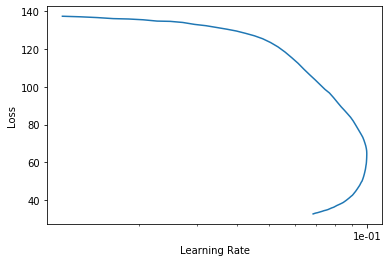

In [0]:
learn.recorder.plot()

In [0]:
lr=1e-1
learn.fit_one_cycle(8, slice(lr/10, lr))

In [0]:
learn.unfreeze

In [0]:
learn.lr_find()

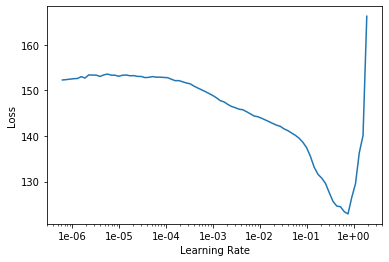

In [0]:
learn.recorder.plot()

In [0]:
lr = 1e-01
learn.fit_one_cycle(8, slice(lr/10, lr))

In [0]:
learn.save('deep_learning_model')

In [0]:
learn.export('export.pkl')